In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, clear_output
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from time import sleep
from livelossplot import PlotLosses
import seaborn as sns
import imageio
import glob
import arviz as az

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
slim = tf.contrib.slim


import numpy as np
from scipy.stats import norm, uniform

import pymc3 as pm
import theano.tensor as tt

import sys
sys.path.append('../models/')
sys.path.append('../')
from ratio_utils import *

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Data Generation (Need Refactoring)

In [38]:
num_samples = 5000

def get_data(mu_1=0.,mu_2=2.,mu_3=0.,scale_p=0.1,scale_q=0.1,scale_m=1.,mtype="mix"):
    
    p = tfd.Normal(loc=mu_1, scale=scale_p)
    q = tfd.Normal(loc=mu_2, scale=scale_q) 
   
    m = tfp.distributions.Cauchy(loc=mu_3, scale=scale_m)
    
        
    p_samples_ = p.sample([num_samples]) 
    q_samples_ = q.sample([num_samples])
    m_samples_ = m.sample([num_samples])
    
    with tf.Session() as sess:
        p_,q_,m_ = sess.run([p_samples_, q_samples_, m_samples_],feed_dict={})
        sess.close() 
    
    return p, q, m, p_,q_,m_

mu_1=-3.
mu_2=3.
mu_3=0.

scale_p=0.1
scale_q=.2
scale_m=2.

# Generate dataset
p, q, m, p_list, q_list, m_list = get_data(mu_1,mu_2,mu_3,scale_p,scale_q,scale_m)
_, _, _, p_list_test, _, m_list_test = get_data(mu_1,mu_2,mu_3,scale_p,scale_q,scale_m)

print(p_list.shape)

def get_paired_data():
    data = [[np.float64(x),np.array([1,0,0])] for x in p_list] + [[np.float64(x),np.array([0,1,0])] for x in q_list] + [[np.float64(x),np.array([0,0,1])] for x in m_list]
    data = np.asarray(data)
    np.random.shuffle(data)
    return data

data = get_paired_data()
X = np.asarray([np.float(x) for x in (data[:,0])])
y = np.asarray([x for x in (data[:,1])])
y = np.where(y)[1]

(5000,)


## Model and Inference (MCMC via NUTS)

In [49]:
# init = 13*[0.]
init = post_weights[10]

Softmax.0 __str__ = [15000     3]
y_obs __str__ = [15000]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b3, b2, b1, t3, t2, t1, s2, s1, q5, q4, q3, q2, q1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1251 seconds.
There were 139 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 330 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6531622378602893, but should be close to 0.8. Try to increase the number of tuning steps.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'q1'}>,
        <AxesSubplot:title={'center':'q1'}>],
       [<AxesSubplot:title={'center':'q2'}>,
        <AxesSubplot:title={'center':'q2'}>],
       [<AxesSubplot:title={'center':'q3'}>,
        <AxesSubplot:title={'center':'q3'}>],
       [<AxesSubplot:title={'center':'q4'}>,
        <AxesSubplot:title={'center':'q4'}>],
       [<AxesSubplot:title={'center':'q5'}>,
        <AxesSubplot:title={'center':'q5'}>],
       [<AxesSubplot:title={'center':'s1'}>,
        <AxesSubplot:title={'center':'s1'}>],
       [<AxesSubplot:title={'center':'s2'}>,
        <AxesSubplot:title={'center':'s2'}>],
       [<AxesSubplot:title={'center':'t1'}>,
        <AxesSubplot:title={'center':'t1'}>],
       [<AxesSubplot:title={'center':'t2'}>,
        <AxesSubplot:title={'center':'t2'}>],
       [<AxesSubplot:title={'center':'t3'}>,
        <AxesSubplot:title={'center':'t3'}>],
       [<AxesSubplot:title={'center':'b1'}>,
        <AxesSubplot:title={'center':'b1'}>],

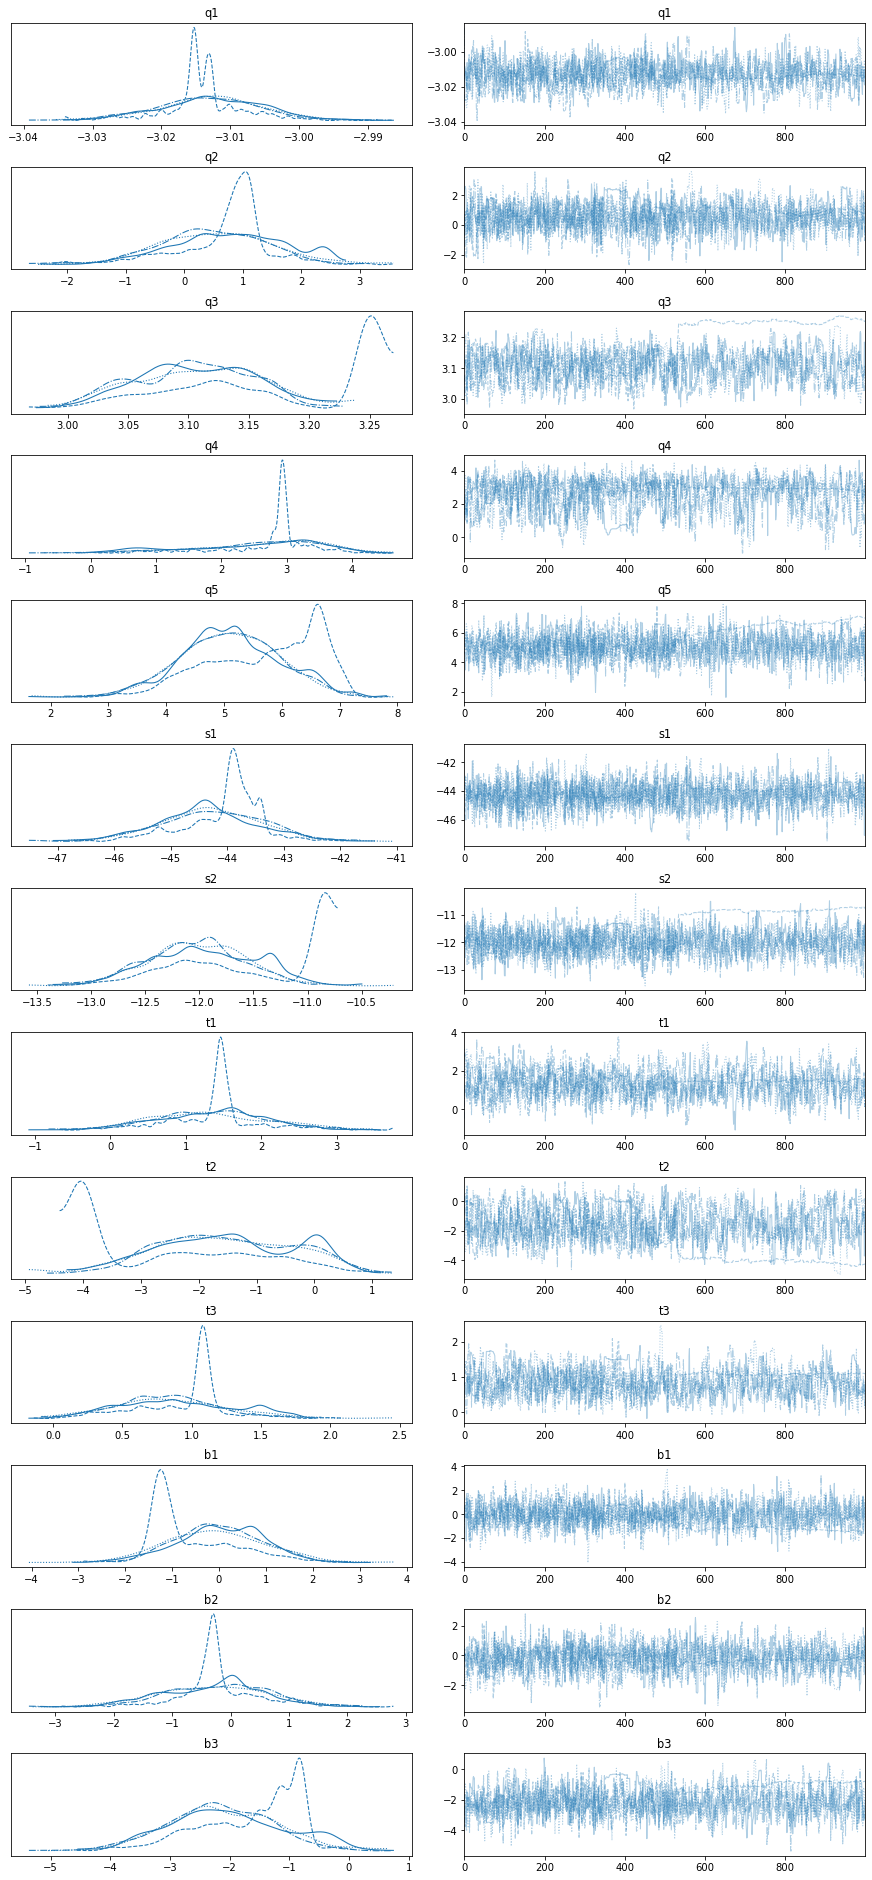

In [50]:
with pm.Model() as ratio_critic:
    # create shared variables that can be changed later on
    x = pm.Data("x_obs", X)
    y_shared = pm.Data("y_obs", y)
    
    # increase sigma
    q1 = pm.Normal("q1", mu=init[0], sigma=1)
    q2 = pm.Normal("q2", mu=init[1], sigma=1)
    q3 = pm.Normal("q3", mu=init[2], sigma=1)
    q4 = pm.Normal("q4", mu=init[3], sigma=1)
    q5 = pm.Normal("q5", mu=init[4], sigma=1)
    s1 = pm.Normal("s1", mu=init[5], sigma=1)
    s2 = pm.Normal("s2", mu=init[6], sigma=1)
    t1 = pm.Normal("t1", mu=init[7], sigma=1)
    t2 = pm.Normal("t2", mu=init[8], sigma=1)
    t3 = pm.Normal("t3", mu=init[9], sigma=1)
    b1 = pm.Normal("b1", mu=init[10], sigma=1)
    b2 = pm.Normal("b2", mu=init[11], sigma=1)
    b3 = pm.Normal("b3", mu=init[12], sigma=1)
    
    h1 = (x-q1)*(x-q1)*s1 + (x-q2)*t1 + b1 
    h2 = (x-q3)*(x-q3)*s2 + (x-q4)*t2 + b2
    h3 = t3*(x-q5) + b3
    
    pred = pm.math.stack([h1,h2,h3],axis=1)
    logits = tt.nnet.softmax(pred-pm.math.maximum(pred,1))
    
    tt.printing.Print(logits)(logits.shape)
    tt.printing.Print(y_shared)(y_shared.shape)
    
    y_observed = pm.Categorical(
        "y_observed",
        p = logits,
        observed=y_shared,
    )

#     prior = pm.sample_prior_predictive()
    idata = pm.sample(cores=4,return_inferencedata=True, random_seed=1) # cores=4, chains=4, return_inferencedata=True

    
az.plot_trace(idata.posterior)

## Posterior Predictive on Test Data

In [8]:
with ratio_critic:
    # change the value and shape of the data
    pm.set_data(
        {
            "x_obs": [-1.0, 0.0, 10.0, 1.0],
            # use dummy values with the same shape:
            "y_obs": [0,2,2,1],
        }
    )

    post_pred = pm.sample_posterior_predictive(idata.posterior)
    
post_pred["y_observed"].mean(axis=0)

array([0.0775 , 2.     , 2.     , 1.05925])

## Helper Function for Viz

In [51]:
def log_ratio_predictive(x,weights):
    posterior_prediction=[]
    for i,weight in enumerate(weights):
        if i%5==0:
            [q1,q2,q3,q4,q5,s1,s2,t1,t2,t3,b1,b2,b3]=weight
            h1 = (x-q1)*(x-q1)*s1 + (x-q2)*t1 + b1 
            h2 = (x-q3)*(x-q3)*s2 + (x-q4)*t2 + b2
            h3 = t3*(x-q5) + b3
            pred = h1 - h2
            posterior_prediction.append(pred)
    posterior_prediction=np.array([xi for xi in posterior_prediction])
    return posterior_prediction.T.tolist(), posterior_prediction.T, posterior_prediction.mean(0), posterior_prediction.std(0) 

In [52]:
sw_ = np.asarray([idata.posterior.q1.values[0,-500:], idata.posterior.q2.values[0,-500:], idata.posterior.q3.values[0,-500:], idata.posterior.q4.values[0,-500:],
idata.posterior.q5.values[0,-500:], idata.posterior.s1.values[0,-500:], idata.posterior.s2.values[0,-500:], idata.posterior.t1.values[0,-500:],
idata.posterior.t2.values[0,-500:], idata.posterior.t3.values[0,-500:], idata.posterior.b1.values[0,-500:], idata.posterior.b2.values[0,-500:],
idata.posterior.b3.values[0,-500:]]).T
sw_.shape

(500, 13)

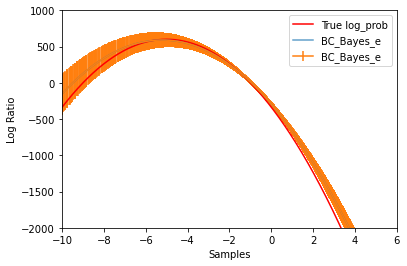

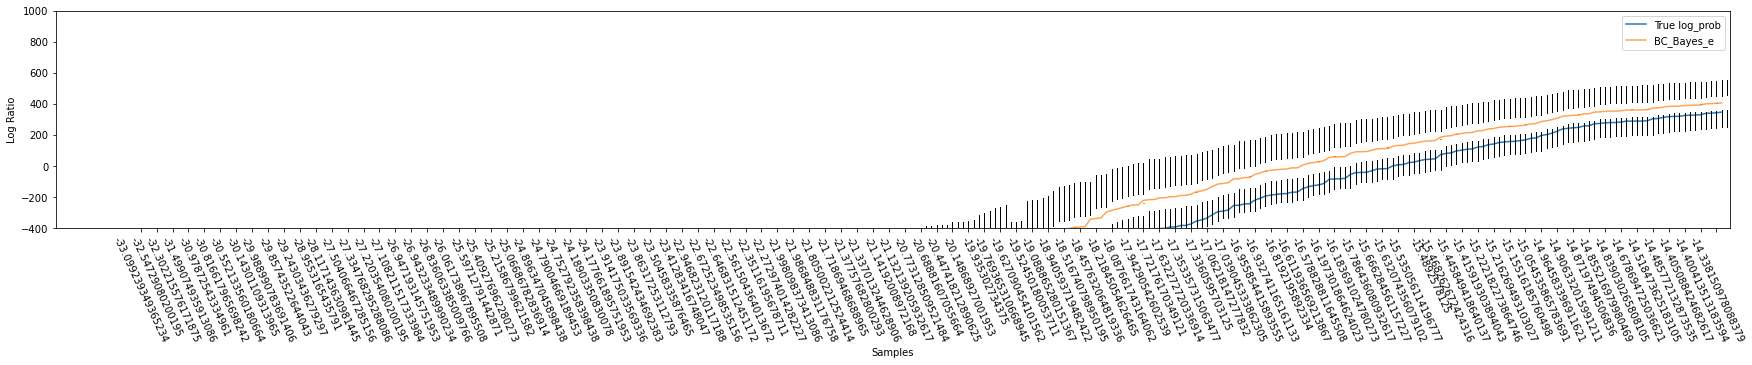

Text(0, 0.5, 'KLD')

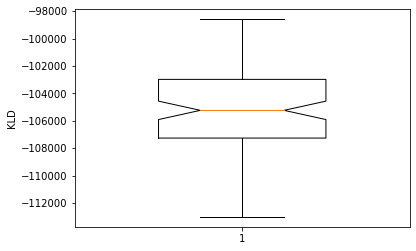

In [53]:
x_s = X# np.asarray([np.float(x) for x in p_list])#X
post,kl_post, post_pred,post_std = log_ratio_predictive(x_s, np.squeeze(sw_))

x_sorted = []
m_sorted = []
s_sorted = []
p_sorted = []
[(x_sorted.append(a),m_sorted.append(b), s_sorted.append(c), p_sorted.append(d)) for a,b,c,d in sorted(zip(x_s,post_pred, post_std, post))]

fig1, ax = plt.subplots()
plt.plot(x_sorted, norm.logpdf(x_sorted,mu_1,scale_p)-norm.logpdf(x_sorted,mu_2,scale_q),label='True log_prob',c='r')
plt.plot(x_sorted, m_sorted,label='BC_Bayes_e',alpha=0.7)
quan = [np.abs(np.quantile(p_, .05)-np.quantile(p_, .95)) for p_ in p_sorted]
plt.errorbar(x_sorted, m_sorted, yerr = quan,label='BC_Bayes_e')

#     plt.scatter(x_sorted,norm.logpdf(x_sorted,mu_1,scale_p)-norm.logpdf(x_sorted,mu_2,scale_q),label='True log_prob',alpha=0.99,s=5.)

plt.xlabel("Samples")
plt.ylabel("Log Ratio")
plt.legend(loc='upper right')
plt.xlim(-10,6)
plt.ylim(-2000,1000)
plt.show()

fig1, ax = plt.subplots(figsize=(30,4))
plt.plot(norm.logpdf(x_sorted[100:400],mu_1,scale_p)-norm.logpdf(x_sorted[100:400],mu_2,scale_q),label='True log_prob',alpha=0.99)
plt.plot(m_sorted[100:400],label='BC_Bayes_e',alpha=0.7)
plt.boxplot(p_sorted[100:400],widths=0.05,notch=True,labels=x_sorted[100:400], showfliers=False, showbox=False, showcaps=False)
plt.xlabel("Samples")
plt.ylabel("Log Ratio")
plt.legend(loc='upper right')
plt.xticks(rotation = -65)
plt.locator_params(axis='x', nbins=100)
plt.ylim(-400,1000)

plt.show()

fig1, ax = plt.subplots()
plt.boxplot(kl_post.mean(0),widths=0.5,notch=True, showfliers=False)
plt.ylabel("KLD")

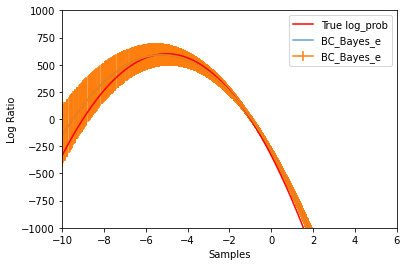

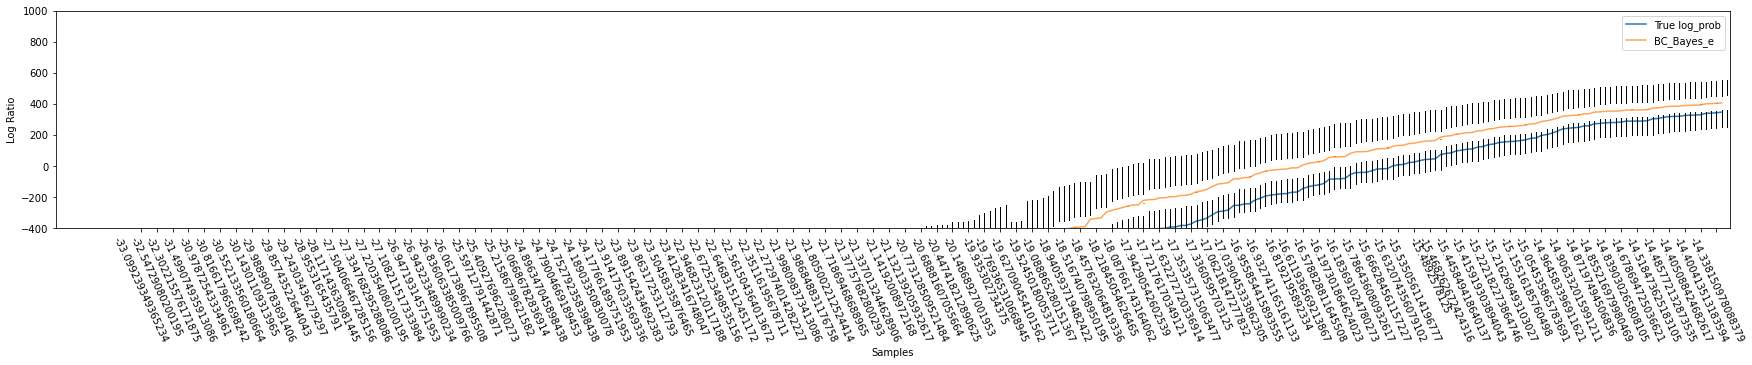

Text(0, 0.5, 'KLD')

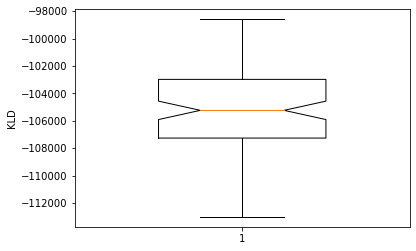

In [46]:
x_s = X# np.asarray([np.float(x) for x in p_list])#X
post,kl_post, post_pred,post_std = log_ratio_predictive(x_s, np.squeeze(sw_))

x_sorted = []
m_sorted = []
s_sorted = []
p_sorted = []
[(x_sorted.append(a),m_sorted.append(b), s_sorted.append(c), p_sorted.append(d)) for a,b,c,d in sorted(zip(x_s,post_pred, post_std, post))]

fig1, ax = plt.subplots()
plt.plot(x_sorted, norm.logpdf(x_sorted,mu_1,scale_p)-norm.logpdf(x_sorted,mu_2,scale_q),label='True log_prob',c='r')
plt.plot(x_sorted, m_sorted,label='BC_Bayes_e',alpha=0.7)
quan = [np.abs(np.quantile(p_, .05)-np.quantile(p_, .95)) for p_ in p_sorted]
plt.errorbar(x_sorted, m_sorted, yerr = quan,label='BC_Bayes_e')

#     plt.scatter(x_sorted,norm.logpdf(x_sorted,mu_1,scale_p)-norm.logpdf(x_sorted,mu_2,scale_q),label='True log_prob',alpha=0.99,s=5.)

plt.xlabel("Samples")
plt.ylabel("Log Ratio")
plt.legend(loc='upper right')
plt.xlim(-10,6)
plt.ylim(-1000,1000)
plt.show()

fig1, ax = plt.subplots(figsize=(30,4))
plt.plot(norm.logpdf(x_sorted[100:400],mu_1,scale_p)-norm.logpdf(x_sorted[100:400],mu_2,scale_q),label='True log_prob',alpha=0.99)
plt.plot(m_sorted[100:400],label='BC_Bayes_e',alpha=0.7)
plt.boxplot(p_sorted[100:400],widths=0.05,notch=True,labels=x_sorted[100:400], showfliers=False, showbox=False, showcaps=False)
plt.xlabel("Samples")
plt.ylabel("Log Ratio")
plt.legend(loc='upper right')
plt.xticks(rotation = -65)
plt.locator_params(axis='x', nbins=100)
plt.ylim(-400,1000)

plt.show()

fig1, ax = plt.subplots()
plt.boxplot(kl_post.mean(0),widths=0.5,notch=True, showfliers=False)
plt.ylabel("KLD")

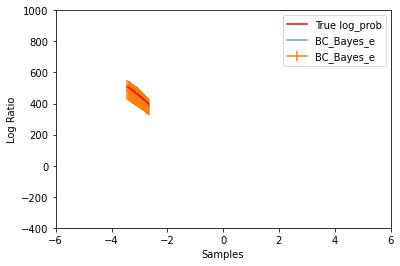

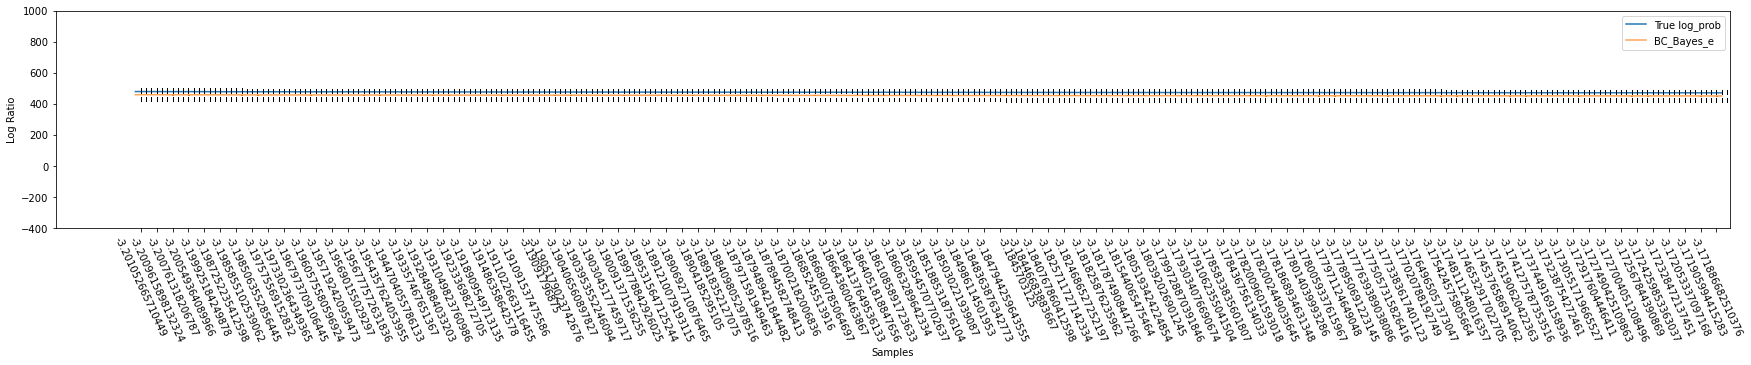

Text(0, 0.5, 'KLD')

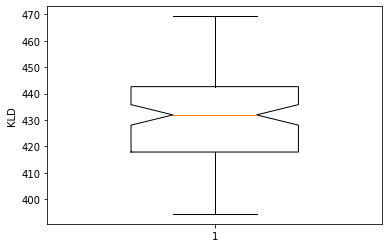

In [54]:
x_s = np.asarray([np.float(x) for x in p_list])#X
post,kl_post, post_pred,post_std = log_ratio_predictive(x_s, np.squeeze(sw_))

x_sorted = []
m_sorted = []
s_sorted = []
p_sorted = []
[(x_sorted.append(a),m_sorted.append(b), s_sorted.append(c), p_sorted.append(d)) for a,b,c,d in sorted(zip(x_s,post_pred, post_std, post))]

fig1, ax = plt.subplots()
plt.plot(x_sorted, norm.logpdf(x_sorted,mu_1,scale_p)-norm.logpdf(x_sorted,mu_2,scale_q),label='True log_prob',c='r')
plt.plot(x_sorted, m_sorted,label='BC_Bayes_e',alpha=0.7)
quan = [np.abs(np.quantile(p_, .05)-np.quantile(p_, .95)) for p_ in p_sorted]
plt.errorbar(x_sorted, m_sorted, yerr = quan,label='BC_Bayes_e')

#     plt.scatter(x_sorted,norm.logpdf(x_sorted,mu_1,scale_p)-norm.logpdf(x_sorted,mu_2,scale_q),label='True log_prob',alpha=0.99,s=5.)

plt.xlabel("Samples")
plt.ylabel("Log Ratio")
plt.legend(loc='upper right')
plt.xlim(-6,6)
plt.ylim(-400,1000)
plt.show()

fig1, ax = plt.subplots(figsize=(30,4))
plt.plot(norm.logpdf(x_sorted[100:400],mu_1,scale_p)-norm.logpdf(x_sorted[100:400],mu_2,scale_q),label='True log_prob',alpha=0.99)
plt.plot(m_sorted[100:400],label='BC_Bayes_e',alpha=0.7)
plt.boxplot(p_sorted[100:400],widths=0.05,notch=True,labels=x_sorted[100:400], showfliers=False, showbox=False, showcaps=False)
plt.xlabel("Samples")
plt.ylabel("Log Ratio")
plt.legend(loc='upper right')
plt.xticks(rotation = -65)
plt.locator_params(axis='x', nbins=100)
plt.ylim(-400,1000)

plt.show()

fig1, ax = plt.subplots()
plt.boxplot(kl_post.mean(0),widths=0.5,notch=True, showfliers=False)
plt.ylabel("KLD")

In [48]:
true_KL = np.log(scale_q/scale_p) + ((scale_p**2 + (mu_1-mu_2)**2)/(2*scale_q**2)) - 0.5
print(true_KL)

450.31814718055983


In [32]:
with open('posterior_weights.npy', 'wb') as f:
    np.save(f, sw_)

In [4]:
with open('posterior_weights.npy', 'rb') as f:
    post_weights = np.load(f)